In [1]:
import sys
import os

# Get the root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the root directory to the Python path
sys.path.append(root_dir)

In [2]:
import torch
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [3]:
SEED = 381
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [4]:
folder="data/1000-Cameras-Dataset"
x_col=["Release_date", "Max_resolution", "Low_resolution", "Effective_pixels", "Zoom", "Normal_focus_range", "Macro_focus_range", "Storage_included","Weight","Dimensions"]
target_col=["price"]

In [7]:
def load_and_clean(npy_filename, y_filename, x_col, target_col):
    """
    Load the feature array (npy_filename) and label array (y_filename),
    drop rows in the feature array that contain any NaNs, and apply
    the same mask to the label array.
    """
    # Load numpy arrays
    X = np.load(os.path.join(folder, npy_filename))
    y = np.load(os.path.join(folder, y_filename))
    
    # Ensure the number of rows matches between X and y
    if X.shape[0] != y.shape[0]:
        raise ValueError("The number of rows in {} and {} do not match.".format(npy_filename, y_filename))
    
    # Create a boolean mask for rows that do NOT have any NaN values in X
    valid_rows = ~np.isnan(X).any(axis=1)

    # Filter both arrays using the valid_rows mask
    X_clean = X[valid_rows]
    y_clean = y[valid_rows]
    
    # Convert arrays to DataFrames
    df_X = pd.DataFrame(X_clean)
    df_y = pd.DataFrame(y_clean)
    df_X.columns = x_col
    df_y.columns = target_col
    return df_X, df_y

X_train, y_train = load_and_clean('N_train.npy', 'y_train.npy',x_col, target_col)
X_test, y_test   = load_and_clean('N_test.npy',  'y_test.npy', x_col, target_col)
X_val, y_val     = load_and_clean('N_val.npy',   'y_val.npy', x_col, target_col)

In [5]:
def load_and_fill_missing(npy_filename, y_filename, x_col, target_col, global_means):
    """
    Load the feature array (npy_filename) and label array (y_filename),
    and fill missing values using global means.
    """
    # Load numpy arrays
    X = np.load(os.path.join(folder, npy_filename))
    y = np.load(os.path.join(folder, y_filename))
    
    # Ensure the number of rows matches between X and y
    if X.shape[0] != y.shape[0]:
        raise ValueError("The number of rows in {} and {} do not match.".format(npy_filename, y_filename))
    
    # Convert arrays to DataFrames
    df_X = pd.DataFrame(X, columns=x_col)
    df_y = pd.DataFrame(y, columns=target_col)
    
    # Fill missing values using global means
    for col in df_X.columns:
        if df_X[col].dtype in [np.float64, np.int64]:  # Numerical columns
            df_X[col] = df_X[col].fillna(global_means[col])
        else:  # Categorical or non-numeric columns
            df_X[col].fillna("_new_", inplace=True)
    
    return df_X, df_y

# Load all datasets
X_train = np.load(os.path.join(folder, 'N_train.npy'))
y_train = np.load(os.path.join(folder, 'y_train.npy'))
X_test = np.load(os.path.join(folder, 'N_test.npy'))
y_test = np.load(os.path.join(folder, 'y_test.npy'))
X_val = np.load(os.path.join(folder, 'N_val.npy'))
y_val = np.load(os.path.join(folder, 'y_val.npy'))

# Combine all feature data for mean computation
df_X_all = pd.DataFrame(np.vstack((X_train, X_test, X_val)), columns=x_col)

global_means = df_X_all.mean()

# Apply missing value imputation
X_train, y_train = load_and_fill_missing('N_train.npy', 'y_train.npy', x_col, target_col, global_means)
X_test, y_test = load_and_fill_missing('N_test.npy', 'y_test.npy', x_col, target_col, global_means)
X_val, y_val = load_and_fill_missing('N_val.npy', 'y_val.npy', x_col, target_col, global_means)

In [6]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import torch

def load_custom_dataset(X_train, y_train, X_test, y_test, X_val, y_val):
    """
    Given training, testing, and validation dataframes/series, this function:
      - Standardizes the numerical features (using StandardScaler fit on training data).
      - Converts the datasets to PyTorch tensors.
      - Uses DataLoaders (with batch_size=1) to concatenate all data onto the specified device.
      - Returns a dictionary with keys: 'train_input', 'train_label', 'val_input', 'val_label', 'test_input', 'test_label'.
    
    Note: This function assumes that 'device' is defined globally (e.g., device = torch.device("cuda" if torch.cuda.is_available() else "cpu")).
    """
    # Standardize the numerical data: fit on training, then transform validation and test.
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.values)
    X_val_scaled   = scaler.transform(X_val.values)
    X_test_scaled  = scaler.transform(X_test.values)
    
    # Convert data and labels to PyTorch tensors (dtype float32)
    train_data_tensor   = torch.tensor(X_train_scaled, dtype=torch.float32)
    train_target_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    
    val_data_tensor     = torch.tensor(X_val_scaled, dtype=torch.float32)
    val_target_tensor   = torch.tensor(y_val.values, dtype=torch.float32)
    
    test_data_tensor    = torch.tensor(X_test_scaled, dtype=torch.float32)
    test_target_tensor  = torch.tensor(y_test.values, dtype=torch.float32)
    
    # Create DataLoaders with batch_size=1 (for concatenation)
    train_loader = DataLoader(TensorDataset(train_data_tensor, train_target_tensor), batch_size=1)
    val_loader   = DataLoader(TensorDataset(val_data_tensor, val_target_tensor), batch_size=1)
    test_loader  = DataLoader(TensorDataset(test_data_tensor, test_target_tensor), batch_size=1)
    
    # Initialize empty tensors on the target device (assumes global variable 'device')
    train_inputs  = torch.empty(0, train_data_tensor.shape[1], device=device)
    train_labels  = torch.empty(0, dtype=torch.float32, device=device)
    val_inputs    = torch.empty(0, val_data_tensor.shape[1], device=device)
    val_labels    = torch.empty(0, dtype=torch.float32, device=device)
    test_inputs   = torch.empty(0, test_data_tensor.shape[1], device=device)
    test_labels   = torch.empty(0, dtype=torch.float32, device=device)
    
    # Concatenate training data
    for data, labels in tqdm(train_loader, desc="Processing training data"):
        train_inputs  = torch.cat((train_inputs, data.to(device)), dim=0)
        train_labels  = torch.cat((train_labels, labels.to(device)), dim=0)
    
    # Concatenate validation data
    for data, labels in tqdm(val_loader, desc="Processing validation data"):
        val_inputs  = torch.cat((val_inputs, data.to(device)), dim=0)
        val_labels  = torch.cat((val_labels, labels.to(device)), dim=0)
    
    # Concatenate test data
    for data, labels in tqdm(test_loader, desc="Processing test data"):
        test_inputs  = torch.cat((test_inputs, data.to(device)), dim=0)
        test_labels  = torch.cat((test_labels, labels.to(device)), dim=0)
    
    # Prepare the final dataset dictionary, reshaping labels to have a second dimension
    dataset = {
        'train_input': train_inputs,
        'train_label': train_labels.reshape(-1, 1),
        'val_input':   val_inputs,
        'val_label':   val_labels.reshape(-1, 1),
        'test_input':  test_inputs,
        'test_label':  test_labels.reshape(-1, 1)
    }
    
    return dataset

# Example usage:
# Assuming that X_train, y_train, X_test, y_test, X_val, y_val have been defined (e.g., via load_and_clean),
# and that 'device' is defined as below:
#
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#
dataset = load_custom_dataset(X_train, y_train, X_test, y_test, X_val, y_val)


Processing test data: 100%|██████████| 208/208 [00:00<00:00, 8451.26it/s]


In [7]:
print("Train data shape: {}".format(dataset['train_input'].shape))
print("Train target shape: {}".format(dataset['train_label'].shape))
print("Test data shape: {}".format(dataset['test_input'].shape))
print("Test target shape: {}".format(dataset['test_label'].shape))
print("====================================")

Train data shape: torch.Size([664, 10])
Train target shape: torch.Size([664, 1])
Test data shape: torch.Size([208, 10])
Test target shape: torch.Size([208, 1])


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.83e+02 | test_loss: 4.96e+02 | reg: 2.98e+03 | : 100%|█| 50/50 [00:01<00:00, 28.75it


saving model version 0.1


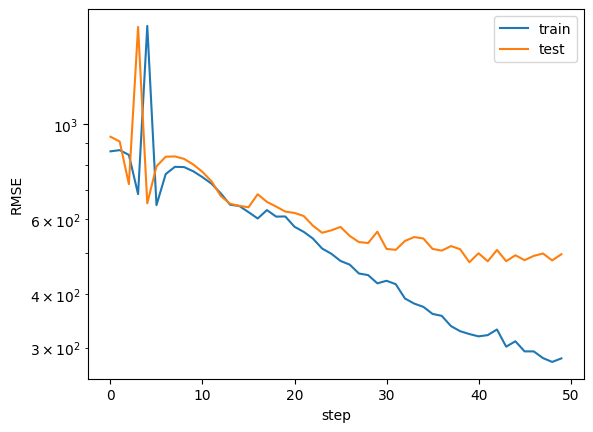

In [10]:
model = KAN(width=[10, 21, 5, 1], grid=6, k=3, seed=381, device=device)
results = model.fit(dataset, opt="Adam", steps=50, lamb=1, lamb_entropy=10.)

plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.02e+02 | test_loss: 4.53e+02 | reg: 2.14e+03 | : 100%|█| 80/80 [00:02<00:00, 38.74it


saving model version 0.1


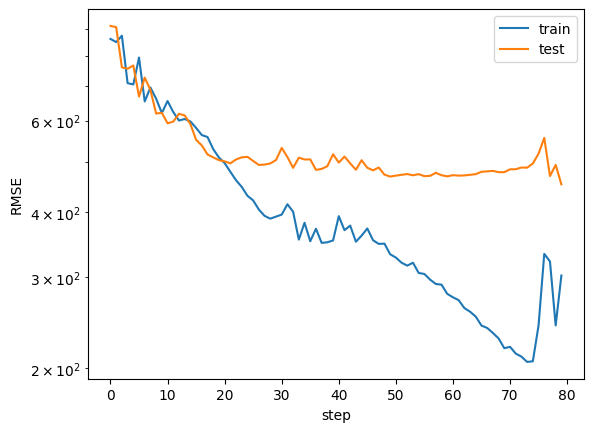

In [42]:
model = KAN(width=[10, 21, 5, 1], grid=5, k=3, seed=381, device=device)
results = model.fit(dataset, opt="Adam", steps=80, lamb=1, lamb_entropy=10.)

plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.48e+02 | test_loss: 4.97e+02 | reg: 4.12e+03 | : 100%|█| 30/30 [00:01<00:00, 23.56it


saving model version 0.1


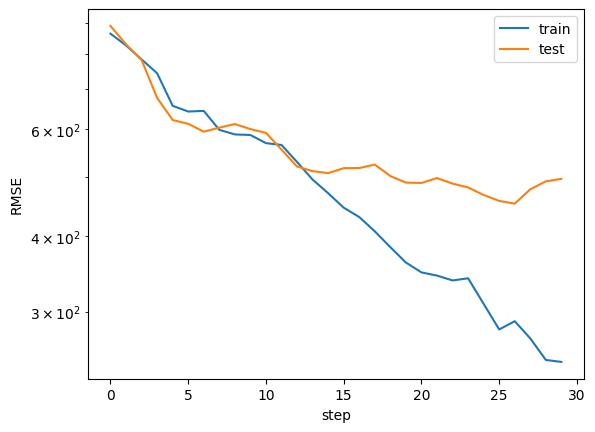

In [15]:
model = KAN(width=[10, 50, 1], grid=8, k=3, seed=381, device=device)
results = model.fit(dataset, opt="Adam", steps=30, lamb=1, lamb_entropy=10.)

plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.44e+02 | test_loss: 4.76e+02 | reg: 2.41e+03 | : 100%|█| 80/80 [00:01<00:00, 43.93it


saving model version 0.1


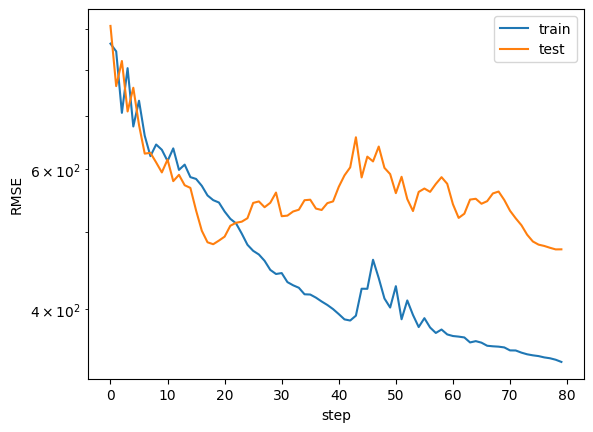

In [29]:
model = KAN(width=[10, 25, 1], grid=3, k=3, seed=381, device=device)
results = model.fit(dataset, opt="Adam", steps=80, lamb=0.1, lamb_entropy=10.)

plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.25e+02 | test_loss: 4.78e+02 | reg: 3.36e+03 | : 100%|█| 80/80 [00:01<00:00, 73.09it


saving model version 0.1


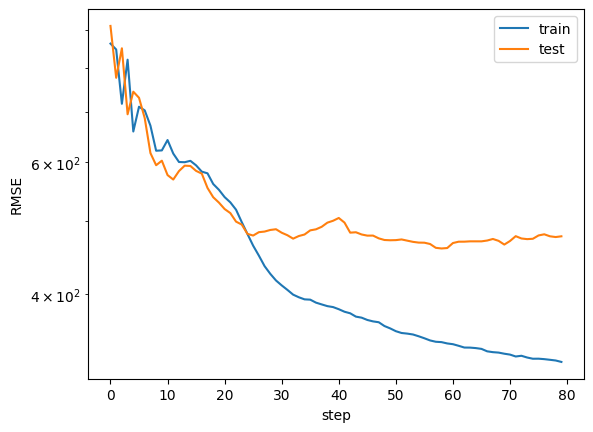

In [27]:
model = KAN(width=[10, 25, 1], grid=3, k=3, seed=381, device=device)
results = model.fit(dataset, opt="Adam", steps=80, lamb=0.1, lamb_entropy=10., update_grid=False)

plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.31e+02 | test_loss: 4.69e+02 | reg: 8.66e+02 | : 100%|█| 40/40 [00:06<00:00,  6.65it


saving model version 0.1


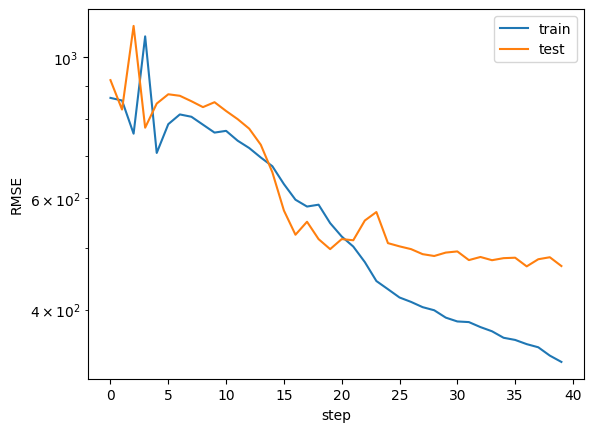

In [14]:
model = KAN(width=[10, 8, 3, 1], grid=6, k=3, seed=381, device=device)
results = model.fit(dataset, opt="Adam", steps=40, lamb=0.1, lamb_entropy=10.)

plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.52e+02 | test_loss: 6.49e+02 | reg: 3.94e+03 | : 100%|█| 80/80 [00:08<00:00,  9.31it


saving model version 0.1


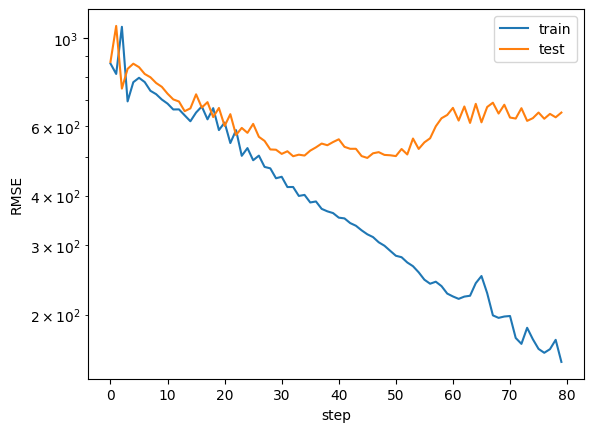

In [31]:
model = KAN(width=[10, 8, 3, 1], grid=6, k=3, seed=381, device=device)
results = model.fit(dataset, opt="Adam", steps=40, lamb=0.1, lamb_entropy=10.)

plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.74e+01 | test_loss: 7.55e+02 | reg: 2.77e+03 | : 100%|█| 30/30 [00:07<00:00,  3.92it

saving model version 0.1


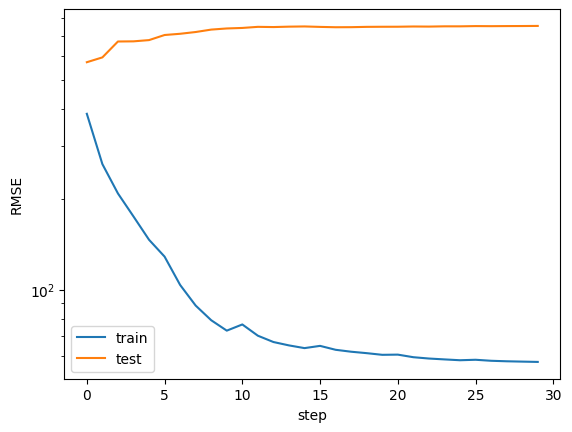

In [19]:
model = KAN(width=[10, 50, 1], grid=9, k=3, seed=381, device=device)
results = model.fit(dataset, opt="LBFGS", steps=30, lamb=0.1, lamb_entropy=10.)

plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.14e+02 | test_loss: 4.87e+02 | reg: 2.11e+03 | : 100%|█| 80/80 [00:10<00:00,  7.89it


saving model version 0.1


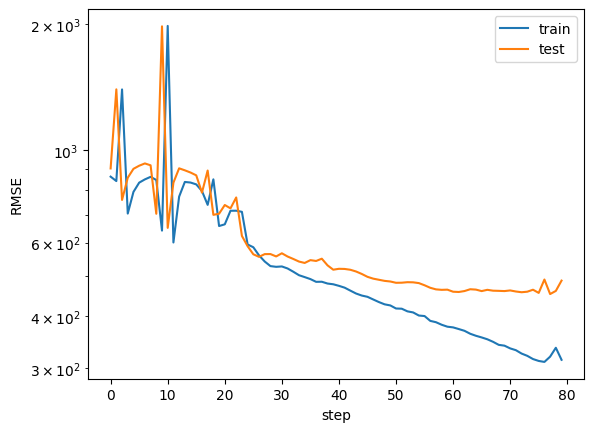

In [34]:
model = KAN(width=[10, 21, 5, 1], grid=5, k=3, seed=381, device=device)
results = model.fit(dataset, opt="Adam", steps=80, lamb=0.1, lamb_entropy=10.)

plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.65e+02 | test_loss: 4.90e+02 | reg: 5.99e+02 | : 100%|█| 80/80 [00:13<00:00,  5.89it


saving model version 0.1


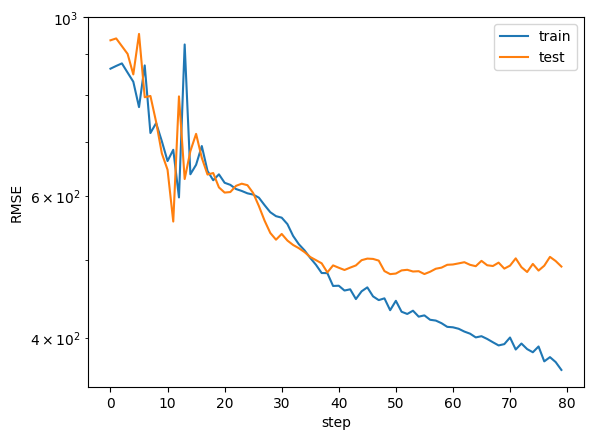

In [12]:
model = KAN(width=[10, 6, 3, 1], grid=3, k=3, seed=381, device=device)
results = model.fit(dataset, opt="Adam", steps=80, lamb=0.1, lamb_entropy=10.)

plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.34e+02 | test_loss: 5.21e+02 | reg: 1.38e+03 | : 100%|█| 80/80 [00:06<00:00, 13.31it


saving model version 0.1


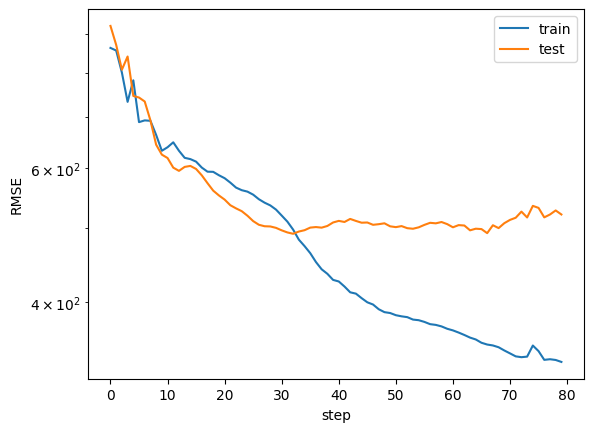

In [29]:
model = KAN(width=[10, 6, 1], grid=4, k=3, seed=381, device=device)
results = model.fit(dataset, opt="Adam", steps=80, lamb=0.1, lamb_entropy=1.)

plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.59e+02 | test_loss: 7.37e+02 | reg: 9.41e+02 | : 100%|█| 30/30 [00:10<00:00,  2.78it

saving model version 0.1


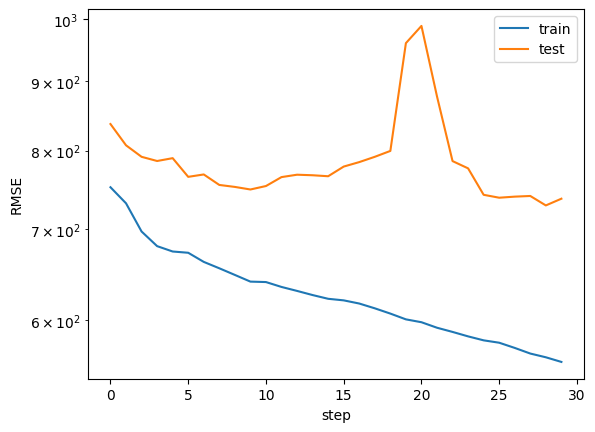

In [26]:
model = KAN(width=[10, 20, 6, 1], grid=3, k=3, seed=381, device=device)
results = model.fit(dataset, opt="LBFGS", steps=30, lamb=0.1, lamb_entropy=10.)

plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.58e+02 | test_loss: 7.21e+02 | reg: 8.94e+02 | : 100%|█| 80/80 [00:12<00:00,  6.24it


saving model version 0.1


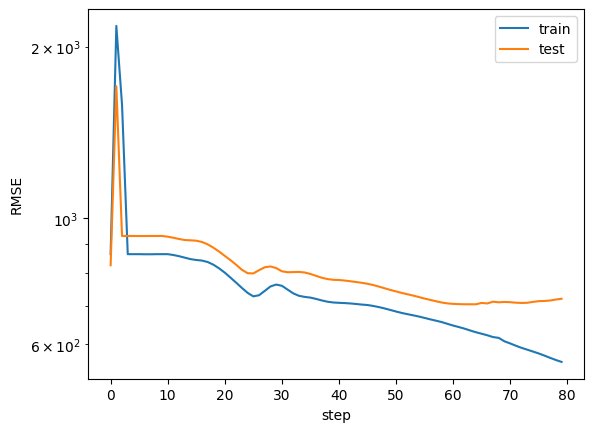

In [17]:
model = KAN(width=[10, [6,2], [4,1], 2, 1], grid=3, k=3, seed=23, device=device)
results = model.fit(dataset, opt="Adam", steps=80, lamb=0.1, lamb_entropy=10.)
plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.21e+02 | test_loss: 8.72e+02 | reg: 4.42e+02 | : 100%|█| 40/40 [01:55<00:00,  2.89s/


saving model version 0.1


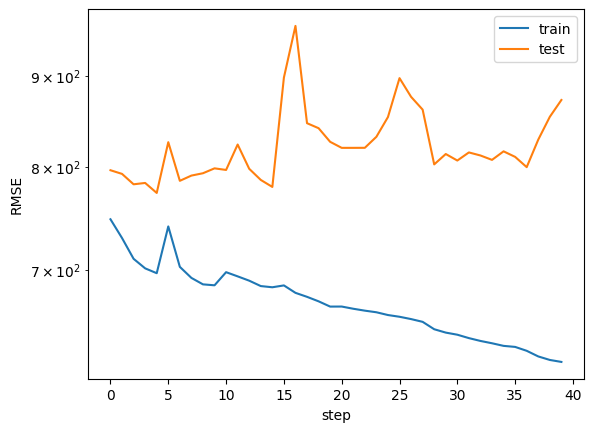

In [18]:
model = KAN(width=[10, [6,2], [4,1], 2, 1], grid=3, k=3, seed=23, device=device)
results = model.fit(dataset, opt="LBFGS", steps=40, lamb=0.1, lamb_entropy=10.)
plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e+02 | test_loss: 1.07e+03 | reg: 4.97e+02 | : 100%|█| 40/40 [01:19<00:00,  1.98s/


saving model version 0.1


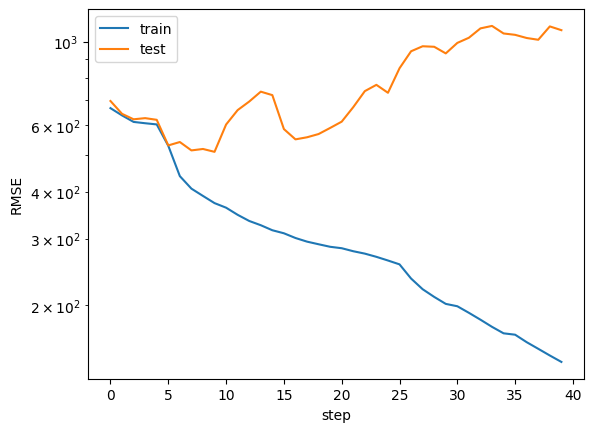

In [20]:
model = KAN(width=[10, 15, 6, 1], grid=3, k=3, seed=381, device=device)
results = model.fit(dataset, opt="LBFGS", steps=40, lamb=0.1, lamb_entropy=10.)

plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.97e+02 | test_loss: 1.58e+03 | reg: 4.17e+02 | : 100%|█| 20/20 [00:55<00:00,  2.77s/


saving model version 0.1


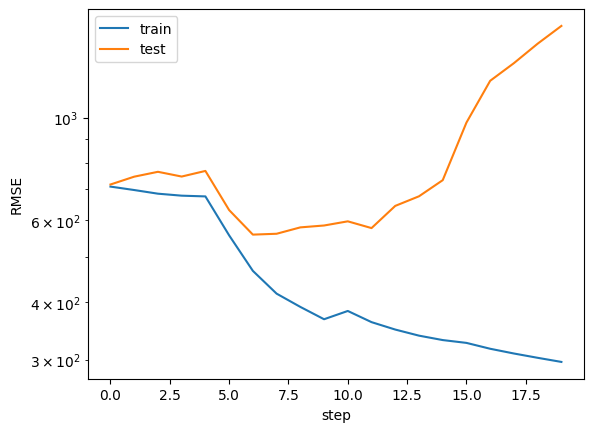

In [23]:
model = KAN(width=[10, 20, 7,  1], grid=3, k=3, seed=381, device=device)
results = model.fit(dataset, opt="LBFGS", steps=20, lamb=0.1, lamb_entropy=10.)

plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

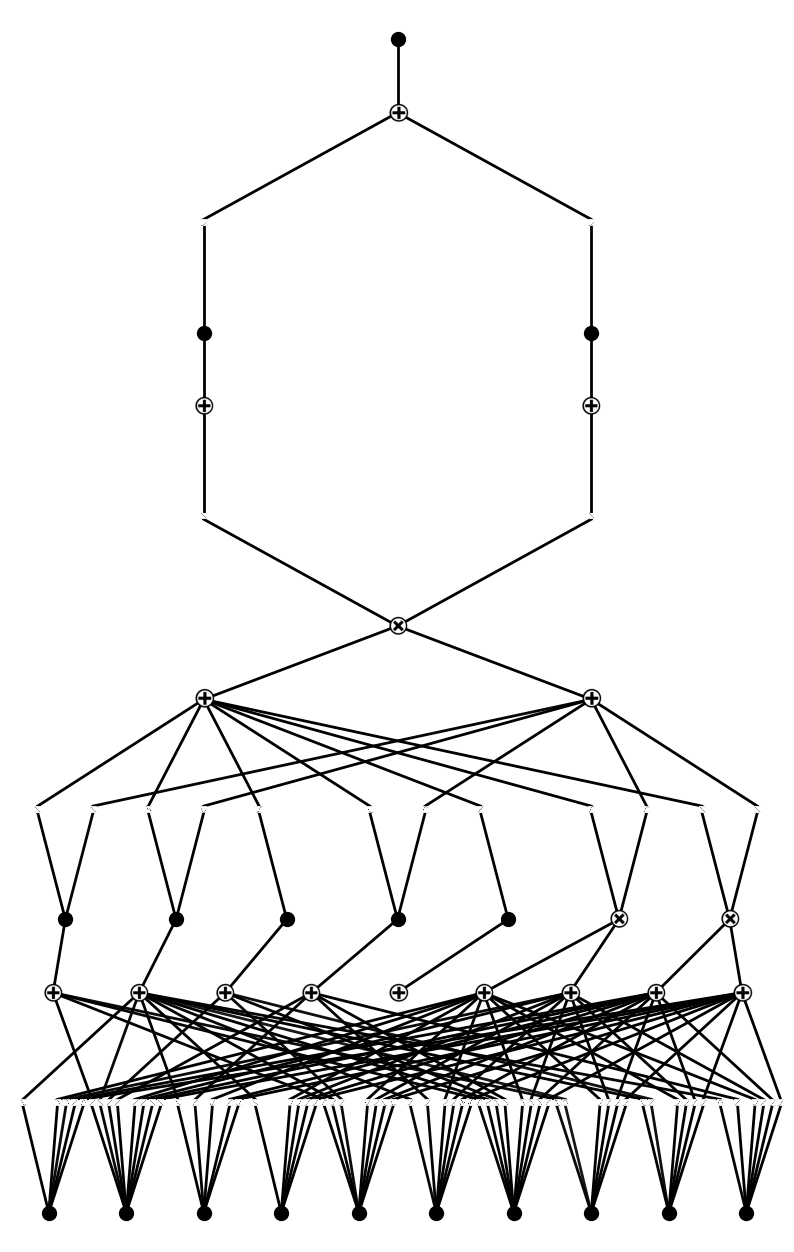

In [46]:
model.plot(beta=50, scale=1)

| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 80/80 [00:12<00:00,  6.30it/s]


saving model version 0.3


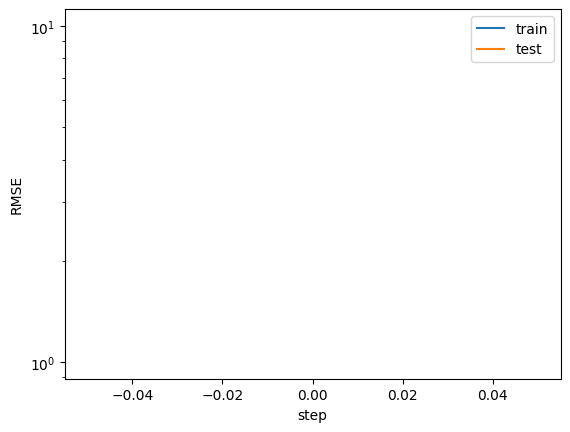

In [47]:
results = model.fit(dataset, opt="Adam", steps=80, lamb=0.1, lamb_entropy=10.)
plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')